## 学習 (Step1:Not Human in the loop) の結果確認
Step1として通常の教師あり学習として学習したモデルを評価する．<br>
ここでは，正解率，Attention，Sigmoid Attentionを評価する．

In [1]:
import os
import cv2
import sys
import torch
import json
import numpy as np
import seaborn as sns
from tqdm import tqdm

from datetime import datetime

import matplotlib.pyplot as plt
from torchvision import datasets, transforms

sys.path.append(os.path.abspath("/taiga/experiments/Sigmoid_Attenion_ViT"))
from models.load_model import load_Sigmoid_Attention_model
from src.utils import Attention_Rollout, heatmap_to_rgb
from datasets.cub200_2011_dataset import CUB2011_Dataset


# check GPU usage
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.device_count()==0: print('Use 1 GPU') 
else: print(f'Use {torch.cuda.device_count()} GPUs')

Use 4 GPUs


### 設定

In [2]:
# Config
result_dir = "../results/run_cub200_2011_FT"

model_pth = os.path.join(result_dir, "best_acc.pt")
config_pth = os.path.join(result_dir, "train_data_lists.json")
#dataset_path="/taiga/share/ABN_Fine-tuning/dataset/cub200"
dataset_path='/taiga/Datasets/CUB_200_2011/images'
num_classes = 200
dataset = "cub200_2011"

filename = result_dir.split('/')[-1]
date = datetime.now().strftime("%Y%m%d_%H%M")
save_dir = f"./notebooks_results/result_{filename}_{date}"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save config to text file
result_text = f"""
# Configuration
model_pth = "{model_pth}"
dataset_path = "{dataset_path}"
num_classes = {num_classes}
dataset = "{dataset}"

# Result
"""

In [3]:
with open(config_pth, 'r', encoding='utf-8') as f:
    data = json.load(f)
print("acc : ", np.max(data['acc_list']))
# Find the maximum value
max_acc = np.max(data['acc_list'])

# Find the index of the maximum value
max_index = np.argmax(data['acc_list'])

print("Max Accuracy:", max_acc)
print("Index of Max Accuracy:", max_index)

acc :  81.21314237573715
Max Accuracy: 81.21314237573715
Index of Max Accuracy: 70


### Modelの読み込み
timmで公開されているモデルは，Attentionの取得ができない．<br>
そこで，local上で改変したモデルを読み込む．このモデルは，重みをそのまま読み込ませることが可能である<br>．
このとき，`model_config`を以下のように設定してモデルを読み込むことで，timmで読み込むものと同じになる．

In [4]:
## timm ViTの読み込み
#from timm.models import create_model
#model = create_model("vit_small_patch16_224", pretrained=False, num_classes=num_classes)

## localモデルでの読み込み
model = load_Sigmoid_Attention_model(model_type='type1', num_classes=num_classes)

state_dict = torch.load(model_pth, map_location=torch.device('cpu'), weights_only=True)

msg = model.load_state_dict(state_dict, strict=False)
print("model.load_state_dict msg : ", msg)

model = model.to(device)

model_config :  {'img_size': (224, 224), 'patch_size': 16, 'in_chans': 3, 'num_classes': 200, 'global_pool': 'token', 'embed_dim': 384, 'depth': 12, 'num_heads': 6, 'mlp_ratio': 4.0, 'qkv_bias': True, 'qk_norm': False, 'init_values': None, 'class_token': True, 'pos_embed': 'learn', 'no_embed_class': False, 'reg_tokens': 0, 'pre_norm': False, 'fc_norm': None, 'dynamic_img_size': False, 'dynamic_img_pad': False, 'drop_rate': 0.0, 'pos_drop_rate': 0.0, 'patch_drop_rate': 0.0, 'proj_drop_rate': 0.0, 'attn_drop_rate': 0.0, 'drop_path_rate': 0.0, 'weight_init': '', 'fix_init': False, 'embed_layer': <class 'timm.layers.patch_embed.PatchEmbed'>, 'norm_layer': <class 'torch.nn.modules.normalization.LayerNorm'>, 'act_layer': None, 'block_fn': <class 'models.vit.Block'>, 'mlp_layer': <class 'timm.layers.mlp.Mlp'>}
model.load_state_dict msg :  <All keys matched successfully>


### データセットの読み込み

In [5]:
# データセットの用意
if dataset == "cub200":

    transform_test = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize((0.4817, 0.4974, 0.4319), (0.2297, 0.2256, 0.2655)),
    ])

    testset = datasets.ImageFolder(root=os.path.join(dataset_path,'val'), transform=transform_test)
    print(f"dataset : {testset}\nlen(trainset) : {len(testset)}")

    idx_to_class = [k for k, v in testset.class_to_idx.items()]
    #testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=8)

elif dataset == "cub200_2011":
    transform_test = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize((0.4859, 0.4996, 0.4318), (0.1750, 0.1738, 0.1859)),
    ])

    testset = CUB2011_Dataset(json_path="../datasets/cub200_2011_dataset.json", 
                              images_dir_path=dataset_path, 
                              split='test', 
                              img_transform=transform_test)
    idx_to_class = testset.label_list

### 正解率の算出

In [6]:
# Nの最大値を指定
max_n = 5
cnt = 0
correct = [0] * max_n  # 各Nに対する正解数を記録するリスト
mpp_list = []
miss_index = []

model=model.eval()
for i in tqdm(range(len(testset))):
    image, label = testset[i]
    image = image.unsqueeze(0).to(device)

    output = model(image)
    
    # モデルの出力から上位max_n個の予測ラベルを取得
    top_n_predictions = torch.topk(output, max_n).indices.squeeze(0)

    probs = torch.softmax(output, dim=1).squeeze(0)[label]
    mpp_list.append(probs.cpu().item())


    if label in top_n_predictions[:1]:
        pass
    else:
        miss_index.append(i)

    
    # 各Nに対して正解ラベルが含まれているかを確認
    for n in range(max_n):
        if label in top_n_predictions[:n+1]:
            correct[n] += 1
    cnt += 1


topN_accs = []
for n in range(max_n):
    topN_acc = correct[n] / cnt
    print(f"Top-{n+1} Accuracy : {topN_acc:.4f}")
    topN_accs.append(f"Top-{n+1} Accuracy : {topN_acc:.4f}")

print(f"MPP (mean) : {np.mean(mpp_list):.4f}")
print(f"MPP (max) : {np.max(mpp_list):.4f}")
print(f"MPP (min) : {np.min(mpp_list):.4f}")

result_text += "\n".join(topN_accs)
result_text += f"\nMPP (mean) = {np.mean(mpp_list):.4f}"
result_text += f"\nMPP (max) = {np.max(mpp_list):.4f}"
result_text += f"\nMPP (min) = {np.min(mpp_list):.4f}"

with open(os.path.join(save_dir, "result.txt"), "w") as config_file:
    config_file.write(result_text)

100%|██████████| 2374/2374 [01:16<00:00, 31.15it/s]

Top-1 Accuracy : 0.8121
Top-2 Accuracy : 0.8964
Top-3 Accuracy : 0.9305
Top-4 Accuracy : 0.9465
Top-5 Accuracy : 0.9570
MPP (mean) : 0.7180
MPP (max) : 0.9992
MPP (min) : 0.0000


In [7]:
print(len(miss_index))
print(miss_index)

446
[4, 15, 18, 31, 35, 54, 61, 68, 73, 88, 89, 91, 93, 96, 100, 114, 115, 118, 142, 155, 164, 173, 182, 199, 203, 207, 211, 224, 233, 241, 246, 250, 251, 254, 260, 266, 268, 274, 275, 276, 282, 283, 284, 289, 292, 293, 296, 299, 302, 305, 306, 307, 308, 309, 310, 324, 327, 331, 332, 333, 334, 335, 336, 337, 338, 340, 342, 343, 344, 345, 347, 349, 350, 357, 366, 372, 379, 381, 392, 422, 423, 426, 428, 435, 443, 444, 445, 446, 447, 448, 451, 452, 454, 456, 457, 459, 462, 464, 468, 469, 477, 478, 482, 495, 496, 499, 519, 530, 533, 563, 568, 571, 572, 579, 588, 589, 590, 626, 630, 633, 636, 650, 661, 676, 677, 682, 685, 687, 690, 691, 692, 694, 696, 700, 701, 703, 705, 711, 715, 719, 722, 724, 725, 726, 729, 744, 746, 748, 749, 751, 755, 757, 759, 760, 765, 767, 769, 773, 775, 778, 780, 781, 785, 787, 788, 793, 798, 808, 809, 810, 814, 826, 827, 831, 835, 836, 840, 859, 862, 866, 868, 880, 884, 893, 912, 923, 925, 927, 937, 941, 957, 958, 985, 987, 995, 1002, 1009, 1023, 1034, 1064, 1068,

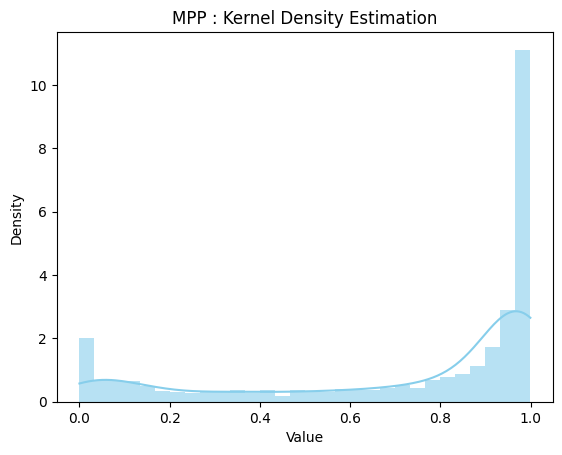

In [8]:
# KDIをプロット
sns.histplot(mpp_list, kde=True, stat="density", bins=30, color='skyblue', alpha=0.6, edgecolor=None)
plt.title('MPP : Kernel Density Estimation')
plt.xlabel('Value')
plt.ylabel('Density')
plt.savefig(os.path.join(save_dir, "label_prob_MPP.pdf"))
plt.savefig(os.path.join(save_dir, "label_prob_MPP.png"))
plt.show()

### 1サンプルにおける評価 (Attention)

attentionを出力したい際には，forward()時に`output_attentions`をTrueにすることで，attentionが出力される．

In [9]:
i = 34  #data sample index

model.eval()
image, label = testset[i]
image = image.unsqueeze(0).to(device)

prediction, attentions = model(image, output_attentions=True)
prediction_label = torch.argmax(prediction)

label_probs = torch.softmax(prediction, dim=1).squeeze(0)[label].cpu().item()
pred_label_probs = torch.softmax(prediction, dim=1).squeeze(0)[prediction_label].cpu().item()

print(f"prediction : {idx_to_class[prediction_label]}  ({pred_label_probs:.4f})")
print(f"label_probs : {idx_to_class[label]}  ({label_probs:.4f})")

prediction : 003.Sooty_Albatross  (0.9596)
label_probs : 003.Sooty_Albatross  (0.9596)


#### 入力画像の可視化

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16798902807235722..1.2153922658205032].


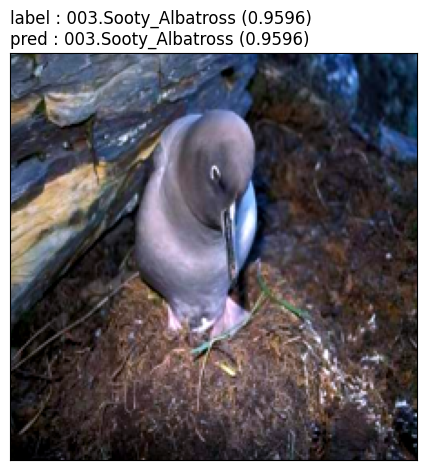

In [10]:
img = image[0].cpu().numpy()
img = np.transpose(img, (1, 2, 0))

# CUBの場合・CIFAR10は適宜変更
mean = np.array([0.4817, 0.4974, 0.4319])
std = np.array([0.2297, 0.2256, 0.2655])

# 逆正規化
img = std * img + mean

# 画像を可視化
plt.imshow(img)
plt.title(f"label : {idx_to_class[label]} ({label_probs:.4f})\npred : {idx_to_class[prediction_label]} ({pred_label_probs:.4f})", loc='left')  # 取得したラベル名をタイトルとして表示
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "prediction_image.pdf"))
plt.savefig(os.path.join(save_dir, "prediction_image.png"))
plt.show()

#### Attentionの可視化

In [11]:
batch = 0
attentions_lsit = []
for layer in range(0, len(attentions)):
    attentions_lsit.append(attentions[layer][batch].to(torch.float).cpu().detach().numpy())

print("np.shape(attentions_lsit) : ", np.shape(attentions_lsit)) #(layer, head, tokens, tokens)

np.shape(attentions_lsit) :  (12, 6, 197, 197)


##### Attention Rolloutでの可視化

In [12]:
attention_rollout = Attention_Rollout(attentions_lsit)

print("np.shape(attention_rollout) : ", np.shape(attention_rollout)) #(tokens, tokens)

np.shape(attention_rollout) :  (197, 197)


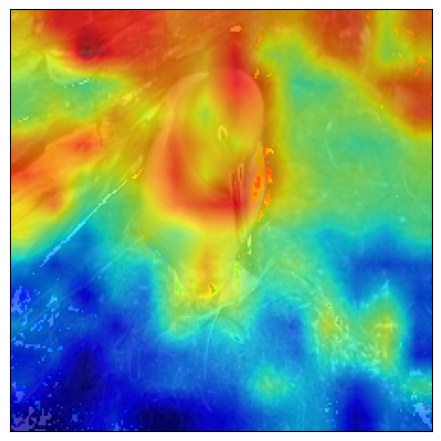

In [13]:
attention_map = cv2.resize(np.reshape(attention_rollout[0][1:], (14,14)), (224, 224), interpolation=cv2.INTER_LINEAR)
attention_map_rgb = heatmap_to_rgb(attention_map)
attention_map = cv2.addWeighted((img* 255).astype(np.uint8), 0.25, attention_map_rgb, 0.75, 0)

plt.imshow(attention_map)
plt.tight_layout()
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)
plt.savefig(os.path.join(save_dir, "attention_rollout_map.pdf"), transparent=True)
plt.savefig(os.path.join(save_dir, "attention_rollout_map.png"), transparent=True)
plt.show()


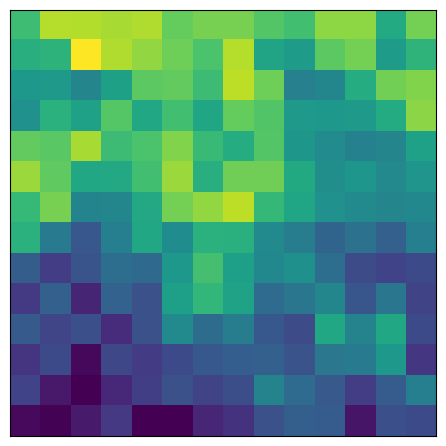

In [14]:
plt.imshow(attention_rollout[0][1:].reshape(14,14))
plt.tight_layout()
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)
#plt.savefig(os.path.join(save_dir, "attention_rollout_patch.pdf"), transparent=True)
#plt.savefig(os.path.join(save_dir, "attention_rollout_patch.png"), transparent=True)
plt.show()

#### Sigmoid Attentionの可視化

In [15]:
sigmoid_att = torch.sigmoid(attentions[-1]).detach().cpu().numpy()
print("np.shape(sigmoid_att) : ", np.shape(sigmoid_att))

np.shape(sigmoid_att) :  (1, 6, 197, 197)


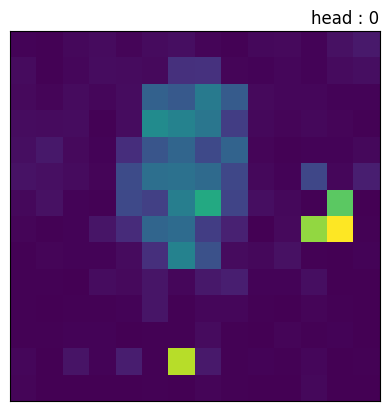

In [16]:
# 0番目のheadを可視化
batch=0
head=0
plt.imshow(np.reshape(sigmoid_att[0][head][0][1:],(14,14)))
plt.title(f"head : {head}", loc="right")
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)
plt.show()

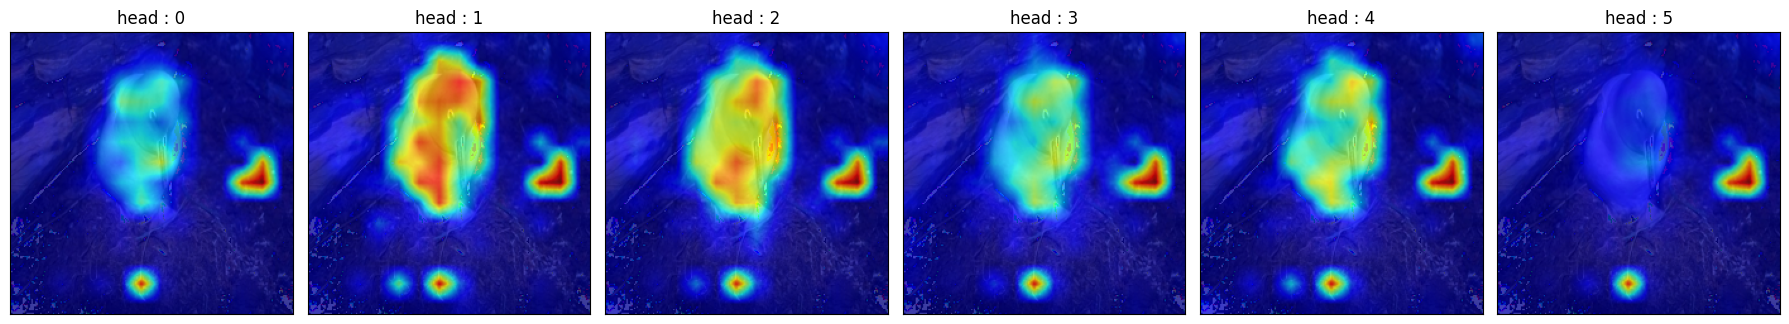

In [17]:
num_heads = np.shape(sigmoid_att)[1]
fig, axes = plt.subplots(1, num_heads, figsize=(18, 5))  # 横並びにするため、1行num_heads列のプロットを作成

for head in range(np.shape(sigmoid_att)[1]):
    attention_map = cv2.resize(np.reshape(sigmoid_att[0][head][0][1:], (14,14)), (224, 224), interpolation=cv2.INTER_LINEAR)
    attention_map_rgb = heatmap_to_rgb(attention_map)
    attention_map = cv2.addWeighted((img* 255).astype(np.uint8), 0.25, attention_map_rgb, 0.75, 0)

    ax = axes[head]  # 各ヘッドに対する軸を取得
    ax.imshow(attention_map)
    ax.set_title(f"head : {head}")
    ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, "sigmoid_attention_heads.pdf"), transparent=True)
plt.savefig(os.path.join(save_dir, "sigmoid_attention_heads.png"), transparent=True)
plt.show()

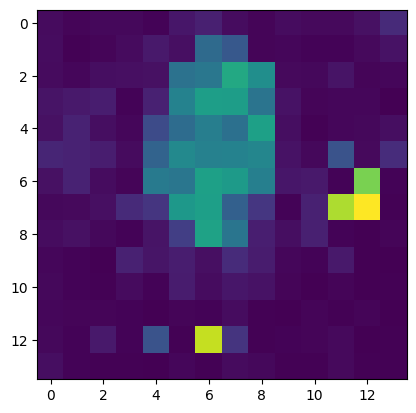

In [18]:
sigmoid_att_mean = np.mean(sigmoid_att, axis=1)

plt.imshow(np.reshape(sigmoid_att_mean[0][0][1:],(14,14)))
#plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)
#plt.savefig(f'attention/vision_encoder_attn_last_layer.png', transparent=True)
#plt.savefig(f'attention/vision_encoder_attn_last_layer.svg', transparent=True)
plt.show()

In [19]:
sigmoid_att_mean.shape

(1, 197, 197)

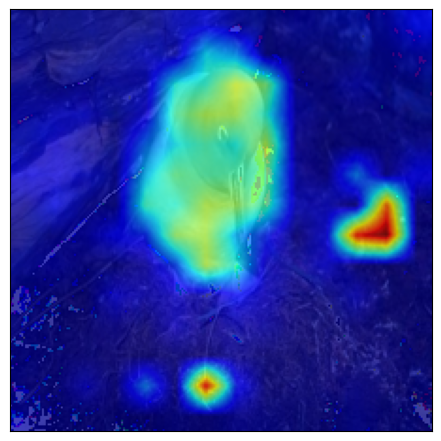

In [20]:
attention_map = cv2.resize(np.reshape(sigmoid_att_mean[0][0][1:], (14,14)), (224, 224), interpolation=cv2.INTER_LINEAR)
attention_map_rgb = heatmap_to_rgb(attention_map)
attention_map = cv2.addWeighted((img* 255).astype(np.uint8), 0.25, attention_map_rgb, 0.75, 0)

plt.imshow(attention_map)
plt.tight_layout()
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)
plt.savefig(os.path.join(save_dir, "sigmoid_map.pdf"), transparent=True)
plt.savefig(os.path.join(save_dir, "sigmoid_map.png"), transparent=True)
plt.show()
